In [4]:
import sys
import os
import pandas as pd
import numpy as np

In [5]:
scripts_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "scripts"))

# Add the "scripts" directory to the Python path if it's not already present.
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

In [6]:
# Now import the module
import data_ingestion
import data_validator

# Isolate a subset of the data population by number of antigen classes

In [7]:
# Test the import:
dirpath = "/Volumes/LaCie_d2_Professional_Media/absolut_antibody/PerClass/RawBindingsPerClassMurine/extracted/processed/"
df = data_ingestion.load_processed_csvs(dirpath, 3)
print(df.shape)

(2542211, 9)


In [8]:
df = data_validator.add_sequence_lengths(df)
df = data_validator.validate_dataframe(df, verbose=True)

Initial DataFrame shape: (2542211, 11)
No missing values found.

Data types of columns:
ID_slide_Variant       object
CDR3                   object
Best                     bool
Slide                  object
Energy                float64
Structure              object
antigen                object
antigen_sequence       object
binding_class          object
CDR3_length             int64
antigen_seq_length      int64
dtype: object
3 antigen cohorts: ['1S78_B', '1OAZ_A', '2ZCH_P']

Rows before deduplication on ['ID_slide_Variant', 'CDR3', 'antigen']: 2542211
Rows after deduplication on ['ID_slide_Variant', 'CDR3', 'antigen']: 2481412


# Split the isolated datasets

In [11]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# STEP 1: Split the Raw Data into Train, Validation, and Test Sets
# -----------------------------------------------------------------------------


# Report the overall class distribution
print("Overall binding_class distribution:")
print(df['binding_class'].value_counts())

# First, split off the test set (20% of the data), stratified by binding_class
train_val, test = train_test_split(
    df, test_size=0.20, stratify=df['binding_class'], random_state=42
)
# Then split the remaining data into training and validation (e.g., 75% train, 25% validation of train_val)
train, val = train_test_split(
    train_val, test_size=0.25, stratify=train_val['binding_class'], random_state=42
)



print(f"Train set: {train.shape[0]} observations")
train = data_validator.validate_dataframe(train, verbose=True)
print(f"Validation set: {val.shape[0]} observations")
val = data_validator.validate_dataframe(val, verbose=True)
print(f"Test set: {test.shape[0]} observations")
test = data_validator.validate_dataframe(test, verbose=True)

Overall binding_class distribution:
binding_class
500kNonMascotte      1479737
LooserExclusive       794861
MascotteExclusive     187997
HeroesExclusive        18817
Name: count, dtype: int64
Train set: 1488846 observations
Initial DataFrame shape: (1488846, 11)
No missing values found.

Data types of columns:
ID_slide_Variant       object
CDR3                   object
Best                     bool
Slide                  object
Energy                float64
Structure              object
antigen                object
antigen_sequence       object
binding_class          object
CDR3_length             int64
antigen_seq_length      int64
dtype: object
3 antigen cohorts: ['2ZCH_P', '1S78_B', '1OAZ_A']

Rows before deduplication on ['ID_slide_Variant', 'CDR3', 'antigen']: 1488846
Rows after deduplication on ['ID_slide_Variant', 'CDR3', 'antigen']: 1488846
Validation set: 496283 observations
Initial DataFrame shape: (496283, 11)
No missing values found.

Data types of columns:
ID_slide_Varian

In [12]:
dirpath = '/Volumes/LaCie_d2_Professional_Media/hyperbind'

fpath = os.path.join(dirpath,"train.csv")
train.to_csv(fpath,index=False)
fpath = os.path.join(dirpath,"val.csv")
val.to_csv(fpath,index=False)
fpath = os.path.join(dirpath,"test.csv")
test.to_csv(fpath,index=False)

# Generate contrastive pairings for train-test-val data

In [13]:
# -----------------------------------------------------------------------------
# STEP 2: Generate Contrastive Pairs
# -----------------------------------------------------------------------------
"""
We create positive pairs by sampling two different rows from the same binding_class.
We create negative pairs by sampling one row from one class and another row from a different class.
Adjust n_pairs_per_class and n_negative_pairs as needed for your training scale.
These functions generate pair indices. You can later use these indices to retrieve the
actual sequences and any other features you need for your contrastive encoder.

Rationale for Positive vs. Negative Pairs in Contrastive Learning:

1. Positive Pairs:
   - Definition: Two observations (e.g., sequences) that are semantically or functionally similar.
   - In our context, we consider two sequences to be a positive pair if they share the same binding class (e.g., both are 'HeroesExclusive').
   - Rationale: The goal of contrastive learning is to learn an embedding space where similar examples are drawn closer together. By providing positive pairs during training, the model is explicitly taught that these pairs should have similar representations.

2. Negative Pairs:
   - Definition: Two observations that are semantically or functionally dissimilar.
   - In our case, a negative pair would be formed from sequences that belong to different binding classes.
   - Rationale: Negative pairs are used to enforce that dissimilar examples are separated in the embedding space. By penalizing the model when negative pairs are mapped too closely together, we ensure that the embedding space has clear boundaries between different classes or cohorts.

3. Importance in Contrastive Learning:
   - The balance of positive and negative pairs is critical. The positive pairs teach the model what similarities look like, while the negative pairs enforce a margin between dissimilar examples.
   - In scenarios with class imbalance (e.g., many more non-binders than binders), careful sampling of negative pairs is essential to avoid biasing the model toward the majority class.
   - The ultimate objective is to generate embeddings that can differentiate between classes while grouping similar items together, which is achieved by optimizing a contrastive loss function (e.g., NT-Xent loss) over these pairs.

In summary, labeling pairs as positive or negative provides explicit signals during training for both similarity and dissimilarity, helping the model learn a structured and discriminative embedding space.
"""

"\nWe create positive pairs by sampling two different rows from the same binding_class.\nWe create negative pairs by sampling one row from one class and another row from a different class.\nAdjust n_pairs_per_class and n_negative_pairs as needed for your training scale.\nThese functions generate pair indices. You can later use these indices to retrieve the\nactual sequences and any other features you need for your contrastive encoder.\n\nRationale for Positive vs. Negative Pairs in Contrastive Learning:\n\n1. Positive Pairs:\n   - Definition: Two observations (e.g., sequences) that are semantically or functionally similar.\n   - In our context, we consider two sequences to be a positive pair if they share the same binding class (e.g., both are 'HeroesExclusive').\n   - Rationale: The goal of contrastive learning is to learn an embedding space where similar examples are drawn closer together. By providing positive pairs during training, the model is explicitly taught that these pairs sh

In [14]:
def generate_pairs(df, n_pos_pairs_per_class=5000, n_neg_pairs=20000, seed=42):
    """
    Generate positive and negative pairs for contrastive learning.
    
    Parameters:
      df (pd.DataFrame): DataFrame containing at least a 'binding_class' column.
      n_pos_pairs_per_class (int): Number of positive pairs to generate per binding_class.
      n_neg_pairs (int): Total number of negative pairs to generate.
      seed (int): Random seed for reproducibility.
      
    Returns:
      pd.DataFrame: A DataFrame with columns ['ID1', 'ID2', 'pair_type'] where pair_type is
                    either 'positive' or 'negative'.
    """
    random.seed(seed)
    pairs = []
    
    # Create positive pairs: within each binding_class
    for binding in df['binding_class'].unique():
        df_class = df[df['binding_class'] == binding]
        indices = df_class.index.tolist()
        # If there are fewer than two examples, skip
        if len(indices) < 2:
            continue
        # Generate n_pos_pairs_per_class random pairs from indices without replacement.
        for _ in range(n_pos_pairs_per_class):
            i, j = random.sample(indices, 2)
            pairs.append({'ID1': i, 'ID2': j, 'pair_type': 'positive'})
    
    # Create negative pairs: across binding_class
    all_indices = df.index.tolist()
    n_total = len(all_indices)
    neg_generated = 0
    while neg_generated < n_neg_pairs:
        i, j = random.sample(all_indices, 2)
        if df.loc[i, 'binding_class'] != df.loc[j, 'binding_class']:
            pairs.append({'ID1': i, 'ID2': j, 'pair_type': 'negative'})
            neg_generated += 1
    pairs_df = pd.DataFrame(pairs)
    return pairs_df



'''
Rationale for constructing composite of Positive vs. Negative Pairs in Contrastive Learning:

Composite Class Creation:
By concatenating 'antigen' and 'binding_class', you define a more granular cohort. This allows the contrastive learning model to learn similarities within each specific group while distinguishing between groups.
	
Positive Pairs:
Sampling pairs within the same composite cohort teaches the model that these sequences are semantically similar.
Negative Pairs:
Sampling pairs across different composite cohorts forces the model to learn that sequences from different groups should be far apart in the embedding space.
Deduplication:
The code drops duplicate pairs (if any) and reports the number of pairs before and after deduplication, ensuring a clean dataset for training.
'''



def generate_composite_pairs(df, n_pos_pairs_per_cohort=5000, n_neg_pairs=20000, seed=42):
    """
    Generate positive and negative pairs for contrastive learning using a composite class.

    A composite class is defined by concatenating the 'antigen' and 'binding_class' columns,
    e.g. "3L95_X_HeroesExclusive". Positive pairs are drawn from the same composite group,
    while negative pairs are drawn from different groups.

    Parameters:
        df (pd.DataFrame): Input DataFrame that must contain 'antigen' and 'binding_class' columns.
        n_pos_pairs_per_cohort (int): Number of positive pairs to sample per composite cohort.
        n_neg_pairs (int): Total number of negative pairs to sample.
        seed (int): Random seed for reproducibility.
        
    Returns:
        pd.DataFrame: A DataFrame with columns ['ID1', 'ID2', 'cohort1', 'cohort2', 'pair_type'].
    """
    random.seed(seed)
    df = df.copy()
    
    # Create a composite column combining antigen and binding_class.
    df['cohort'] = df['antigen'].astype(str) + "_" + df['binding_class'].astype(str)
    
    pairs = []
    
    # Generate positive pairs within each composite cohort.
    for cohort in df['cohort'].unique():
        df_cohort = df[df['cohort'] == cohort]
        indices = df_cohort.index.tolist()
        if len(indices) < 2:
            continue  # Need at least two examples for a pair.
        for _ in range(n_pos_pairs_per_cohort):
            i, j = random.sample(indices, 2)
            pairs.append({
                'ID1': i,
                'ID2': j,
                'cohort1': cohort,
                'cohort2': cohort,
                'pair_type': 'positive'
            })
    
    # Generate negative pairs from different composite cohorts.
    all_indices = df.index.tolist()
    neg_generated = 0
    while neg_generated < n_neg_pairs:
        i, j = random.sample(all_indices, 2)
        cohort_i = df.loc[i, 'cohort']
        cohort_j = df.loc[j, 'cohort']
        if cohort_i != cohort_j:
            pairs.append({
                'ID1': i,
                'ID2': j,
                'cohort1': cohort_i,
                'cohort2': cohort_j,
                'pair_type': 'negative'
            })
            neg_generated += 1
    
    pairs_df = pd.DataFrame(pairs)
    
    # Report deduplication of pairs if needed:
    initial_pair_count = len(pairs_df)
    pairs_df = pairs_df.drop_duplicates(subset=['ID1', 'ID2', 'cohort1', 'cohort2', 'pair_type'])
    final_pair_count = len(pairs_df)
    print(f"Generated {initial_pair_count} pairs; after deduplication: {final_pair_count}")
    
    return pairs_df

In [ ]:
train = pd.read_csv('')

In [26]:
# Generate pairs for each split. (For very large datasets, consider sampling a subset.)
train_pairs = generate_pairs(train, n_pos_pairs_per_class=5000, n_neg_pairs=20000)
val_pairs   = generate_pairs(val,   n_pos_pairs_per_class=1000, n_neg_pairs=2000)
test_pairs  = generate_pairs(test,  n_pos_pairs_per_class=1000, n_neg_pairs=2000)

print("Number of training pairs:", train_pairs.shape[0])
print("Number of validation pairs:", val_pairs.shape[0])
print("Number of test pairs:", test_pairs.shape[0])

Number of training pairs: 40000
Number of validation pairs: 6000
Number of test pairs: 6000


In [16]:
# -----------------------------------------------------------------------------
# Optional: Save the pairs to CSV files for later use in your contrastive learning pipeline.
# -----------------------------------------------------------------------------
dirpath = '/Volumes/LaCie_d2_Professional_Media/hyperbind'
fpath = os.path.join(dirpath,"train_pairs.csv")
train_pairs.to_csv(fpath, index=False)
fpath = os.path.join(dirpath,"val_pairs.csv")
val_pairs.to_csv(fpath, index=False)
fpath = os.path.join(dirpath,"test_pairs.csv")
test_pairs.to_csv(fpath, index=False)

In [27]:
# Generate pairs for each split. (For very large datasets, consider sampling a subset.)
train_pairs = generate_composite_pairs(train, n_pos_pairs_per_cohort=5000, n_neg_pairs=20000)
val_pairs   = generate_composite_pairs(val,   n_pos_pairs_per_cohort=1000, n_neg_pairs=2000)
test_pairs  = generate_composite_pairs(test,  n_pos_pairs_per_cohort=1000, n_neg_pairs=2000)

print("Number of training pairs:", train_pairs.shape[0])
print("Number of validation pairs:", val_pairs.shape[0])
print("Number of test pairs:", test_pairs.shape[0])

Generated 80000 pairs; after deduplication: 79998
Generated 14000 pairs; after deduplication: 13999
Generated 14000 pairs; after deduplication: 13999
Number of training pairs: 79998
Number of validation pairs: 13999
Number of test pairs: 13999


In [18]:
# -----------------------------------------------------------------------------
# Optional: Save the pairs to CSV files for later use in your contrastive learning pipeline.
# -----------------------------------------------------------------------------
dirpath = '/Volumes/LaCie_d2_Professional_Media/hyperbind'
fpath = os.path.join(dirpath,"train_composite_pairs.csv")
train_pairs.to_csv(fpath, index=False)
fpath = os.path.join(dirpath,"val_composite_pairs.csv")
val_pairs.to_csv(fpath, index=False)
fpath = os.path.join(dirpath,"test_composite_pairs.csv")
test_pairs.to_csv(fpath, index=False)

In [19]:
'''
•	Pair Generation:
The function creates positive/negative contrastive pairs by matching two rows from the training data according to the indices provided in pairs_df.
•	Concatenation with Suffixes:
Using suffixes (_1 and _2) keeps the features from each original row distinct, which is useful when you later pass the pair through an encoder or combine them further.
•	Metadata Preservation:
The function also copies over the pairing metadata (e.g., cohort and pair type), which can be used during model training or evaluation.
'''


def build_contrastive_dataframe(train_df, pairs_df):
    """
    Build a contrastive learning DataFrame from a training DataFrame and a pairs DataFrame.
    
    Each row in the returned DataFrame represents a contrastive pair,
    created by concatenating the corresponding rows from train_df for ID1 and ID2.
    The columns from the first row receive a '_1' suffix and those from the second row receive a '_2' suffix.
    Additional metadata (e.g., pair_type, cohort1, cohort2) is included.
    
    Parameters:
        train_df (pd.DataFrame): The training data.
        pairs_df (pd.DataFrame): A DataFrame with columns ['ID1', 'ID2', 'cohort1', 'cohort2', 'pair_type'].
    
    Returns:
        pd.DataFrame: A new DataFrame where each row is a contrastive pair.
    """
    contrastive_rows = []
    
    for _, pair in pairs_df.iterrows():
        # Get the indices from the pair.
        id1 = pair["ID1"]
        id2 = pair["ID2"]
        
        # Retrieve the corresponding rows from the training DataFrame.
        row1 = train_df.loc[id1].to_dict()
        row2 = train_df.loc[id2].to_dict()
        
        # Create a new dictionary with the data from both rows.
        combined_row = {f"{key}_1": value for key, value in row1.items()}
        combined_row.update({f"{key}_2": value for key, value in row2.items()})
        
        # Add the pair metadata.
        combined_row["ID1"] = id1
        combined_row["ID2"] = id2
        combined_row["pair_type"] = pair["pair_type"]
        combined_row["cohort1"] = pair["cohort1"]
        combined_row["cohort2"] = pair["cohort2"]
        
        contrastive_rows.append(combined_row)
    
    return pd.DataFrame(contrastive_rows)

In [20]:
contrastive_df = build_contrastive_dataframe(train, train_pairs)
print("Contrastive Training DataFrame shape:", contrastive_df.shape)
contrastive_df.head()

Contrastive Training DataFrame shape: (79998, 27)


,ID_slide_Variant_1,CDR3_1,Best_1,Slide_1,Energy_1,Structure_1,antigen_1,antigen_sequence_1,binding_class_1,CDR3_length_1,...,antigen_2,antigen_sequence_2,binding_class_2,CDR3_length_2,antigen_seq_length_2,ID1,ID2,pair_type,cohort1,cohort2
0,2126274_04a,CTRRFTTVGPAWFAYW,True,FTTVGPAWFAY,-91.550,125281-LULRURULDR,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,16,...,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,18,237,587840,532634,positive,2ZCH_P_500kNonMascotte,2ZCH_P_500kNonMascotte
1,1085745_03a,CTRDRTGYWYFDVW,True,DRTGYWYFDVW,-86.030,121184-SUDRURULDU,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,14,...,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,11,237,551991,627338,positive,2ZCH_P_500kNonMascotte,2ZCH_P_500kNonMascotte
2,2805469_03b,CAVNLLEPLGHYFDYW,True,NLLEPLGHYFD,-92.115,125218-UULSRDDRRU,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,16,...,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,16,237,658797,471780,positive,2ZCH_P_500kNonMascotte,2ZCH_P_500kNonMascotte
3,6954938_02a,CARDYGSFFYYFDYW,True,RDYGSFFYYFD,-95.150,129440-URDRULDSRU,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,15,...,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,18,237,457965,798123,positive,2ZCH_P_500kNonMascotte,2ZCH_P_500kNonMascotte
4,4308563_04a,CAMGKIYYGNYWYFDVW,True,KIYYGNYWYFD,-87.410,133473-BRDRLDDURU,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,17,...,2ZCH_P,IVGGWECEKHSQPWQVLVASRGRAVCGGVLVHPQWVLTAAHCIRNK...,500kNonMascotte,15,237,747516,808159,positive,2ZCH_P_500kNonMascotte,2ZCH_P_500kNonMascotte


In [21]:
contrastive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79998 entries, 0 to 79997
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_slide_Variant_1    79998 non-null  object 
 1   CDR3_1                79998 non-null  object 
 2   Best_1                79998 non-null  bool   
 3   Slide_1               79998 non-null  object 
 4   Energy_1              79998 non-null  float64
 5   Structure_1           79998 non-null  object 
 6   antigen_1             79998 non-null  object 
 7   antigen_sequence_1    79998 non-null  object 
 8   binding_class_1       79998 non-null  object 
 9   CDR3_length_1         79998 non-null  int64  
 10  antigen_seq_length_1  79998 non-null  int64  
 11  ID_slide_Variant_2    79998 non-null  object 
 12  CDR3_2                79998 non-null  object 
 13  Best_2                79998 non-null  bool   
 14  Slide_2               79998 non-null  object 
 15  Energy_2           

# Analyze class and cohort imbalances in train

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Convert Wide Format to Long Format ---
# For each pair, create a row for the first observation and another for the second.
# We'll include the Energy, binding_class, and cohort columns.

# Observation 1
df_obs1 = contrastive_df[['Energy_1', 'binding_class_1', 'cohort1']].copy()
df_obs1 = df_obs1.rename(columns={
    'Energy_1': 'Energy', 
    'binding_class_1': 'binding_class', 
    'cohort1': 'cohort'
})
df_obs1['observation'] = 'obs1'

# Observation 2
df_obs2 = contrastive_df[['Energy_2', 'binding_class_2', 'cohort2']].copy()
df_obs2 = df_obs2.rename(columns={
    'Energy_2': 'Energy', 
    'binding_class_2': 'binding_class', 
    'cohort2': 'cohort'
})
df_obs2['observation'] = 'obs2'

# Concatenate the two observations into one long DataFrame.
df_long = pd.concat([df_obs1, df_obs2], ignore_index=True)

/var/folders/lg/dh15rq991nb0srz_jbgtk8f80000gn/T/ipykernel_96252/2408890079.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axs[0, 0], data=df_long, x='binding_class', y='Energy',
/Users/meow/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/meow/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_ke

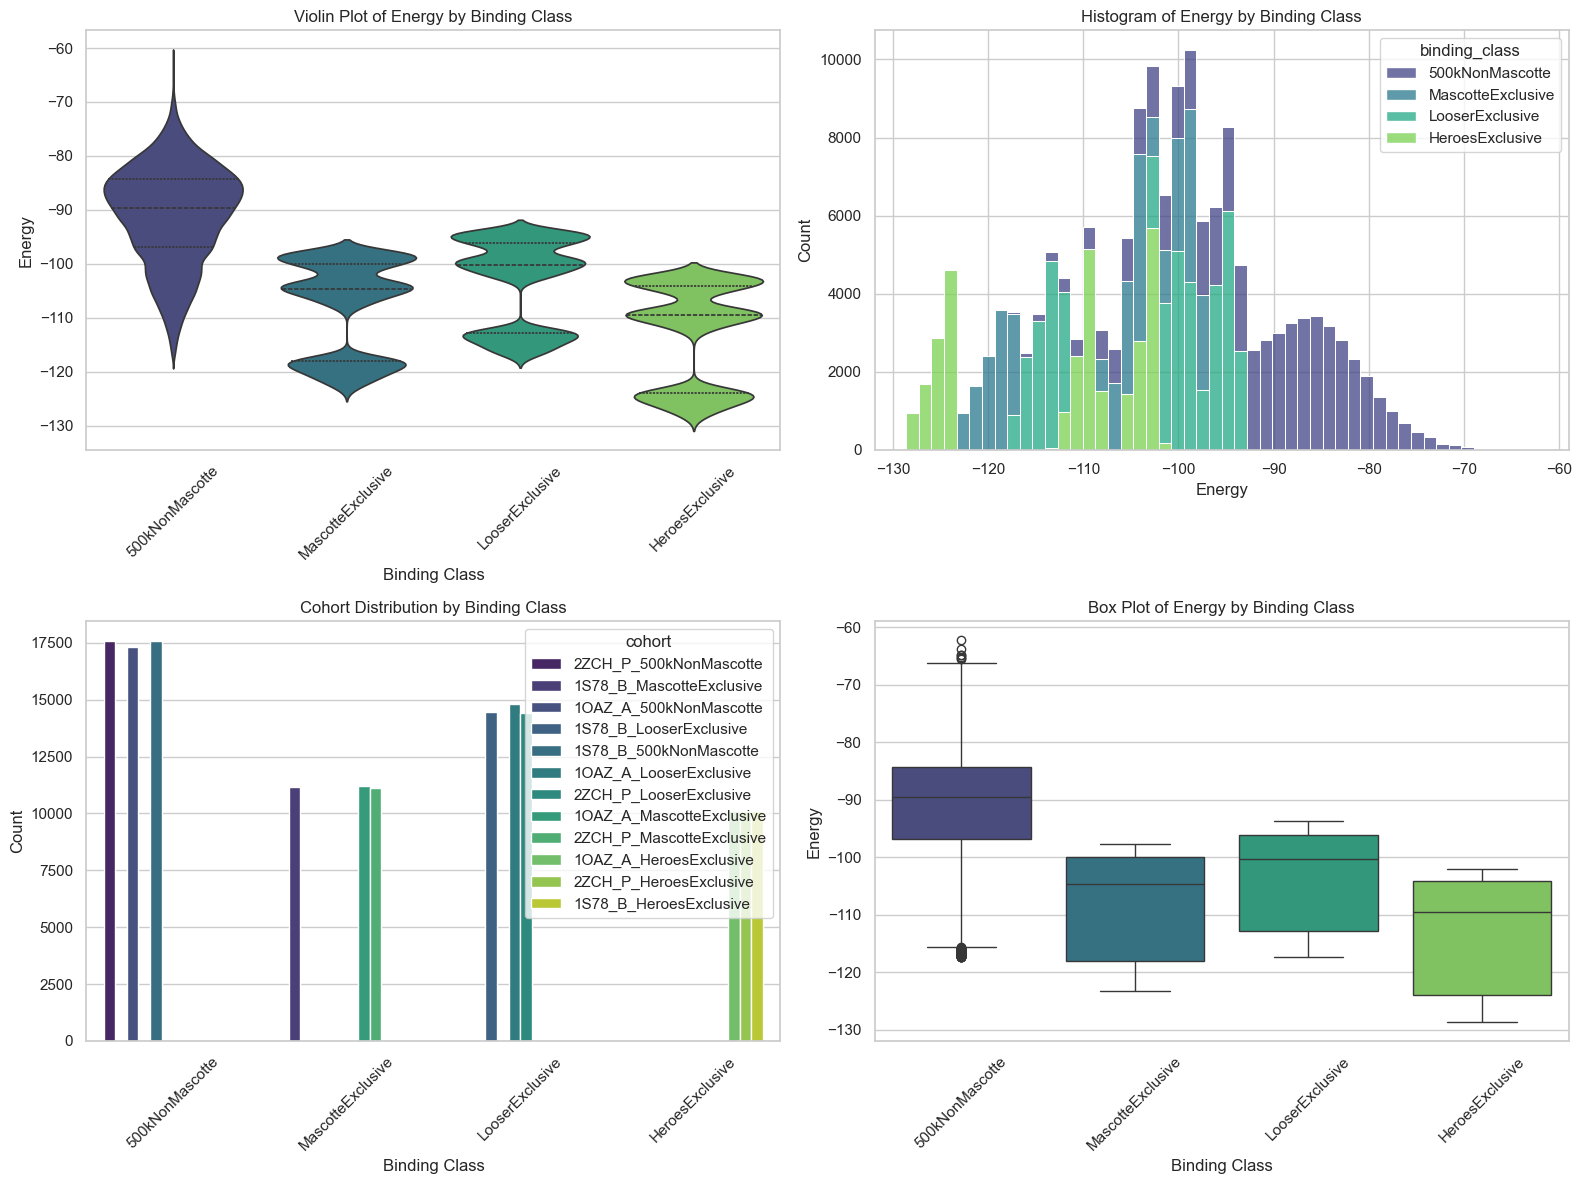

In [23]:
# --- Step 2: Visualize Using Subplots ---
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Violin Plot of Energy by Binding Class
sns.violinplot(ax=axs[0, 0], data=df_long, x='binding_class', y='Energy',
               palette='viridis', inner='quartile')
axs[0, 0].set_title("Violin Plot of Energy by Binding Class")
axs[0, 0].set_xlabel("Binding Class")
axs[0, 0].set_ylabel("Energy")
axs[0, 0].tick_params(axis='x', rotation=45)

# Subplot 2: Histogram of Energy with Stacked Binding Classes
sns.histplot(ax=axs[0, 1], data=df_long, x='Energy', hue='binding_class', 
             multiple='stack', palette='viridis', bins=50)
axs[0, 1].set_title("Histogram of Energy by Binding Class")
axs[0, 1].set_xlabel("Energy")
axs[0, 1].set_ylabel("Count")

# Subplot 3: Count Plot of Cohort Distribution by Binding Class
sns.countplot(ax=axs[1, 0], data=df_long, x='binding_class', hue='cohort', 
              palette='viridis')
axs[1, 0].set_title("Cohort Distribution by Binding Class")
axs[1, 0].set_xlabel("Binding Class")
axs[1, 0].set_ylabel("Count")
axs[1, 0].tick_params(axis='x', rotation=45)

# Subplot 4: Box Plot of Energy by Binding Class
sns.boxplot(ax=axs[1, 1], data=df_long, x='binding_class', y='Energy', 
            palette='viridis')
axs[1, 1].set_title("Box Plot of Energy by Binding Class")
axs[1, 1].set_xlabel("Binding Class")
axs[1, 1].set_ylabel("Energy")
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

/var/folders/lg/dh15rq991nb0srz_jbgtk8f80000gn/T/ipykernel_96252/1166157817.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x="binding_class", y="Energy", palette="viridis", inner="quartile")
/Users/meow/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


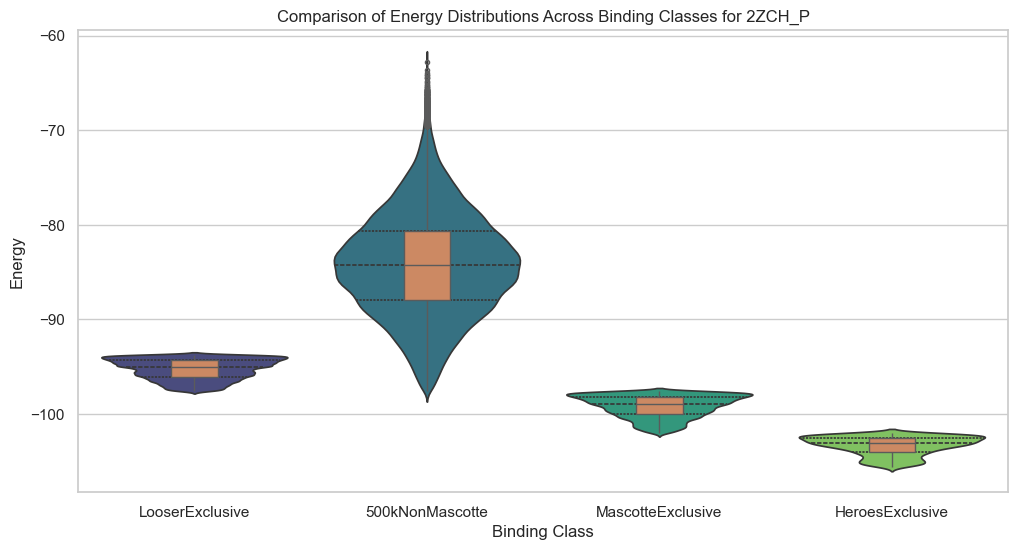

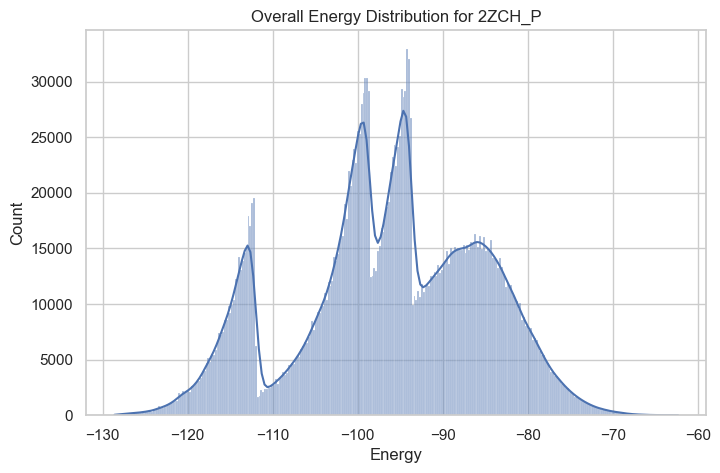

/var/folders/lg/dh15rq991nb0srz_jbgtk8f80000gn/T/ipykernel_96252/1166157817.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x="binding_class", y="Energy", palette="viridis", inner="quartile")
/Users/meow/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


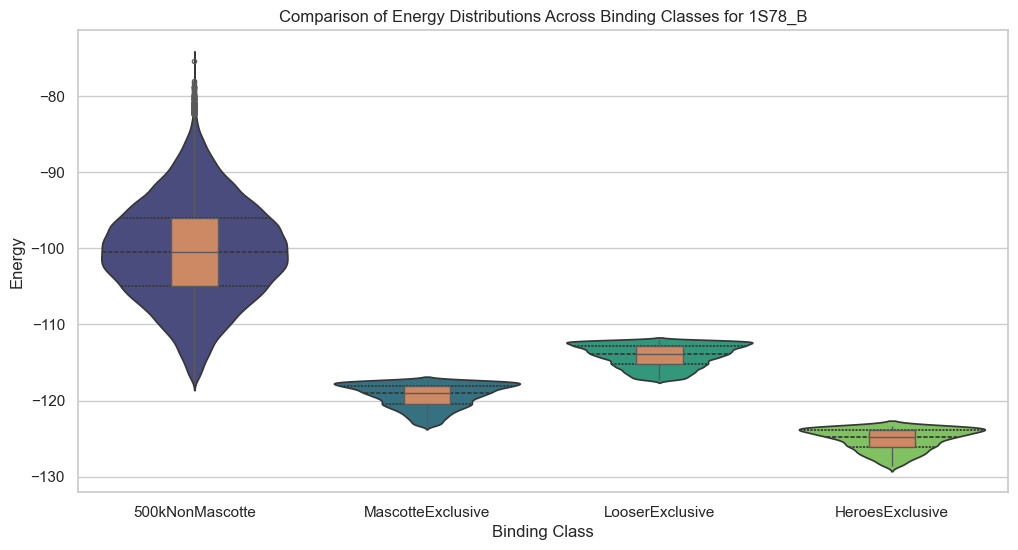

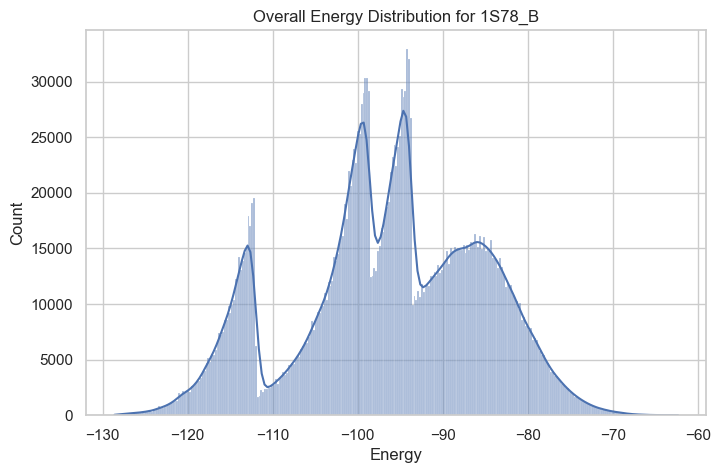

/var/folders/lg/dh15rq991nb0srz_jbgtk8f80000gn/T/ipykernel_96252/1166157817.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x="binding_class", y="Energy", palette="viridis", inner="quartile")
/Users/meow/.pyenv/versions/3.10.13/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


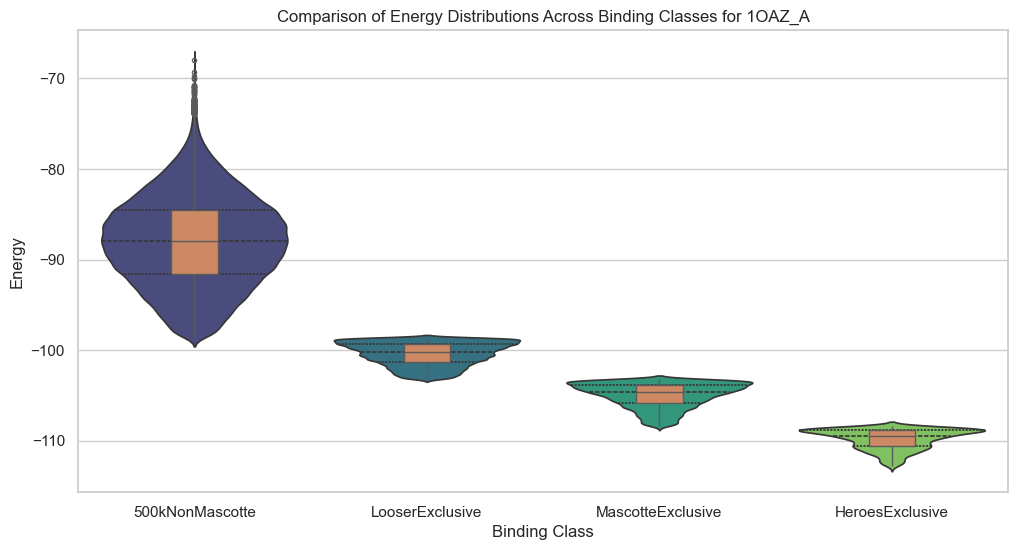

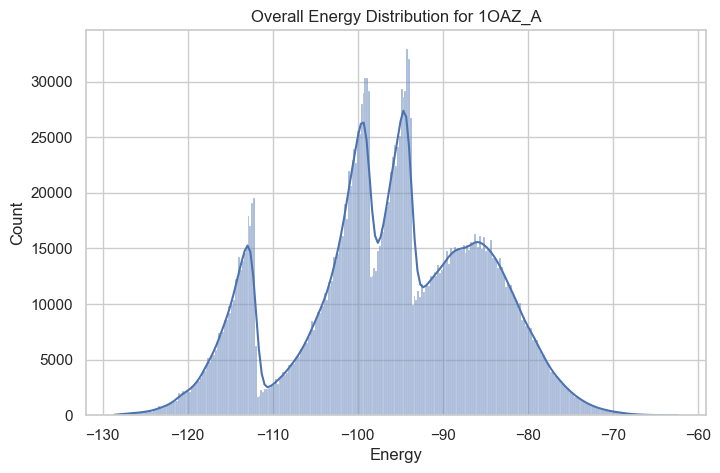

In [24]:
test_cohorts = test['antigen'].unique().tolist()

for cohort in test_cohorts:
    data = test[test['antigen']==cohort]
    
    # Set figure size
    plt.figure(figsize=(12, 6))
    
    # Violin plot to show energy distribution per binding class
    sns.violinplot(data, x="binding_class", y="Energy", palette="viridis", inner="quartile")
    
    # Box plot overlay for summary statistics
    sns.boxplot(data, x="binding_class", y="Energy", width=0.2, boxprops={'zorder': 2}, showcaps=False, fliersize=3)
    
    # Labels and title
    plt.xlabel("Binding Class")
    plt.ylabel("Energy")
    plt.title(f"Comparison of Energy Distributions Across Binding Classes for {cohort}")
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(df['Energy'], kde=True)
    plt.title(f"Overall Energy Distribution for {cohort}")
    plt.show()